# 楽曲の特徴抽出

参考にしたサイト

・<https://sonaeru-blog.com/classification-music/>

・<https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8>


> 音楽の再生



In [0]:
import librosa
import IPython.display as ipd
ipd.Audio('/content/drive/My Drive/Colab Notebooks/violin.mp3')

音楽の情報を可視化する。librosaを使うことで波形を見たり、スペクトラムを見ることができる。

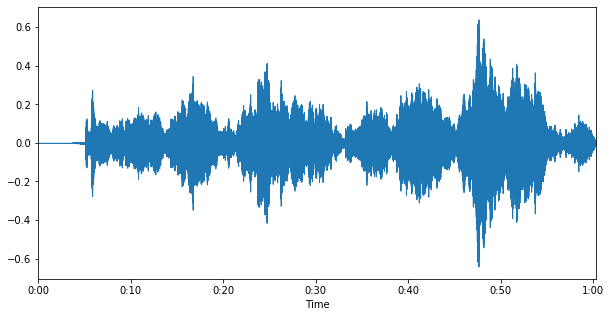

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import librosa.display 
x, sr = librosa.load('/content/drive/My Drive/Colab Notebooks/violin.mp3')
plt.figure(figsize=(10, 5)) 
librosa.display.waveplot(x, sr=sr)

In [0]:
librosa.output.write_wav('ex_violin.wav', x, sr)

In [0]:
import numpy as np
sr = 22050 # sample rate
T = 5.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*220*t)# pure sine wave at 220 HzPlaying the audio
ipd.Audio(x, rate=sr) # load a NumPy arraySaving the audio
librosa.output.write_wav('ex_violin.wav', x, sr)



> 楽曲の特徴量


楽曲の分類を行う上で参考にしたサイトは、(<https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8>)。これらによると、楽曲分類する上で必要とする特徴は、

*   ゼロ交差率
*   スペクトルセントロイド
*   スペクトルロールオフ
*   メル周波数ケプストラム係数
*   クロマ周波数

である。それぞれについて詳しく見たいと思う。





> ゼロ交差率

信号に沿った正と負の変化の割合。音声認識や音楽情報検索にも使われる。




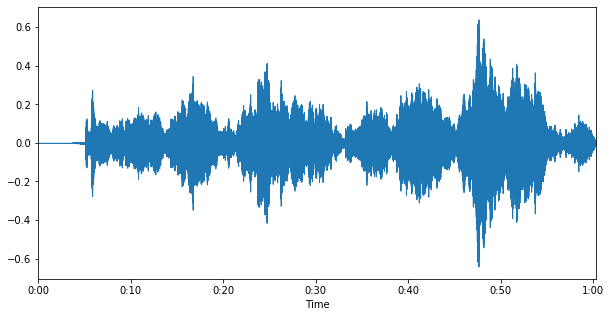

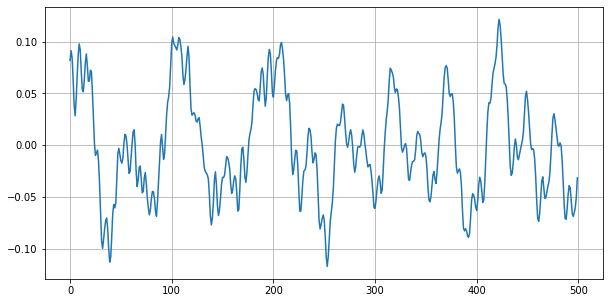

In [0]:
# Load the signal
x, sr = librosa.load('violin.mp3')
#Plot the signal:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)

# Zooming in 
n0 = 600000 #適当な範囲を選択
n1 = 600500 
plt.figure(figsize=(10, 5)) 
plt.plot(x[n0:n1]) 
plt.grid()


ゼロ交差点のカウントをする。なお、この波形は全体の一部である。

In [0]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

37




> スペクトルセントロイド


音の重心のこと。音の周波数の加重平均として計算される。
サンプル音源はクラシック曲(エルガー:『愛の挨拶』)を使っているためか、曲の真ん中では変化が小さい。


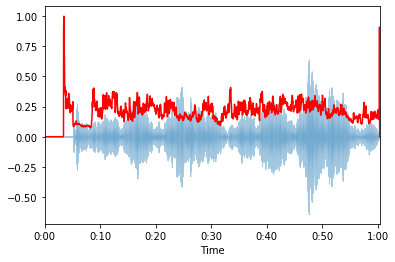

In [0]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0] 
spectral_centroids.shape 

import sklearn
# Computing the time variable for visualization 
frames = range(len(spectral_centroids)) 
t = librosa.frames_to_time(frames) 
# Normalising the spectral centroid for visualisation 
def normalize(x, axis=0): 
  return sklearn.preprocessing.minmax_scale(x, axis=axis) 
#Plotting the Spectral Centroid along the waveform 
librosa.display.waveplot(x, sr=sr, alpha=0.4) 
plt.plot(t, normalize(spectral_centroids), color='r')



> スペクトルロールオフ

スペクトル分布の85%以上を占める周波数の尺度らしい。



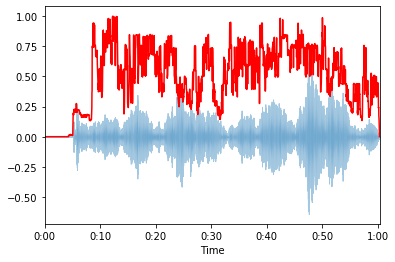

In [0]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0] 
librosa.display.waveplot(x, sr=sr, alpha=0.4) 
plt.plot(t, normalize(spectral_rolloff), color='r')



> メル周波数ケプストラム係数

メル周波数ケプストラム係数(MFCC)は、声の特徴をモデル化したもの。メル周波数の差は実際に人間が知覚する音高と同じであるとされている。説明を読んだ限り、この特徴量がかなり重要であると考えられる。MFCCのみで楽曲判別を試みていた論文もあった。

ケプストラムは、を「スペクトルの対数のフーリエ逆変換」と定義されるらしく、人間の声道の特性を表す特徴量になるという。



(20, 2601)


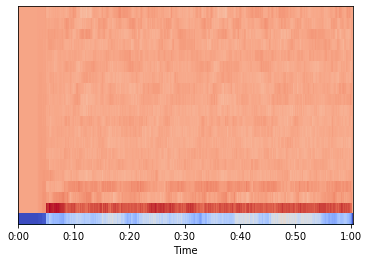

In [0]:
x, fs = librosa.load('violin.mp3')
librosa.display.waveplot(x, sr=sr)
mfccs = librosa.feature.mfcc(x, sr=fs) 
print(mfccs.shape)
 #Displaying the MFCCs: 
librosa.display.specshow(mfccs, sr=sr, x_axis='time')



> クロマ周波数

クロマの特徴は、オクターブの12個の半音(またはクロマ)を表す12個のビンにスペクトル全体が投影される。



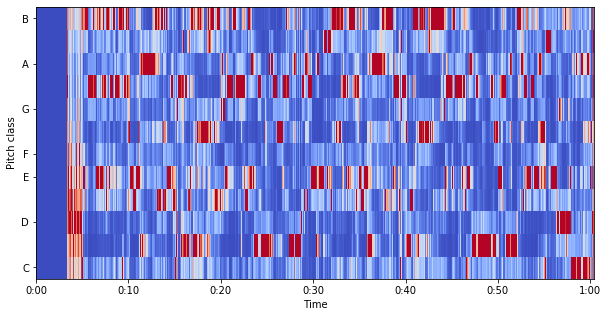

In [0]:
# Loadign the file 
x, sr = librosa.load('violin.mp3') 
hop_length = 512 
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length) 
plt.figure(figsize=(10, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# 深層学習で楽曲分類

音声データから分類する際に使用する特徴を決めたので、実際に特徴抽出を行い、Kerasを用いて分類してみる。使用するデータはGITZANデータセット(IEEE TRANSACTIONS ON SPEECH AND AUDIO PROCESSING, VOL.10, NO.5, JULY 2002 "Musical Genre Classification of Audio Signals")を用いる。

> GIZANデータセット

*  blues
*  classical
*  country
*  disco
*  hiphop
*  jazz
*  metal
*  pop
*  reggae
*  rock

の10種類のジャンルの楽曲が各100曲、合計1000曲入っている。訓練データとテストデータに分けて使っていく。







In [0]:
# 使用するライブラリ群
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

特徴量の抽出を行いファイルに出力する。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


csvファイルに特徴量を書きだす。

In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/My Drive/Colab Notebooks/genres/{g}'):
        songname = f'/content/drive/My Drive/Colab Notebooks/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Pandasによるデータ分析

In [0]:
data = pd.read_csv('data.csv')
data.head(5)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00041.wav,0.386950,0.129172,2390.772194,2463.394088,5403.783991,0.102289,-107.161537,88.466174,-4.174955,55.484199,-8.007365,38.415666,-6.399443,28.574483,-19.820579,13.247096,-19.241852,12.072803,-4.580049,3.791740,-16.991064,11.624591,-7.360204,-3.657303,-7.177438,1.977192,blues
1,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
2,blues.00033.wav,0.260669,0.133165,1430.582003,2075.602343,3246.730367,0.041970,-239.010915,108.669218,34.149350,30.242794,-0.470997,27.296516,-21.389085,14.155847,-24.505631,-1.876820,-28.052265,-11.258263,-16.484101,-7.636357,-12.796291,-15.352031,-13.732282,-7.400161,-10.083954,-13.285140,blues
3,blues.00088.wav,0.377977,0.142049,1006.758962,1530.437061,2074.679121,0.032066,-194.254540,151.857147,-1.197270,39.198065,16.581611,18.257577,-1.396668,14.883665,-11.617614,2.451710,-5.080100,3.946019,-0.900450,0.638456,-8.354744,-7.515805,-8.049329,-5.410957,-2.535688,0.128512,blues
4,blues.00092.wav,0.391010,0.063085,918.405453,1437.609189,1599.673660,0.032318,-332.482336,128.042922,28.936692,41.828353,31.281250,23.353077,5.816310,8.992065,-3.846627,3.733484,-0.858987,-0.424217,1.495610,-1.555774,-0.837087,2.156455,-3.899823,-4.198857,-5.930102,-3.434429,blues


In [0]:
data.shape

(1000, 28)

In [0]:
# Dropping unneccesary columns
data = data.drop('filename', axis=1)

In [0]:
data.shape

(1000, 27)

In [0]:
# ラベルエンコーディング
genre_name = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_name)

# 特徴量のスケーリング
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


> Kerasによる深層学習を使った分類



In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=128)

Epoch 1/30
800/800 [==============================] - 0s 339us/step - loss: 2.1619 - acc: 0.2062
Epoch 2/30
800/800 [==============================] - 0s 32us/step - loss: 1.8533 - acc: 0.3763
Epoch 3/30
800/800 [==============================] - 0s 34us/step - loss: 1.6435 - acc: 0.4113
Epoch 4/30
800/800 [==============================] - 0s 30us/step - loss: 1.4656 - acc: 0.4738
Epoch 5/30
800/800 [==============================] - 0s 31us/step - loss: 1.3264 - acc: 0.5513
Epoch 6/30
800/800 [==============================] - 0s 34us/step - loss: 1.2151 - acc: 0.5725
Epoch 7/30
800/800 [==============================] - 0s 32us/step - loss: 1.1143 - acc: 0.6275
Epoch 8/30
800/800 [==============================] - 0s 32us/step - loss: 1.0320 - acc: 0.6487
Epoch 9/30
800/800 [==============================] - 0s 35us/step - loss: 0.9643 - acc: 0.6812
Epoch 10/30
800/800 [==============================] - 0s 35us/step - loss: 0.9079 - acc: 0.7075
Epoch 11/30
800/800 [=================

テストデータでテスト

In [0]:
test_loss, test_acc = model.evaluate(X_test,y_test)

200/200 [==============================] - 0s 329us/step


In [0]:
print('test_accuracy: ',test_acc)

test_accuracy:  0.655


検証用データセットの用意

In [0]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=128,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/30
600/600 [==============================] - 0s 616us/step - loss: 2.2155 - acc: 0.2133 - val_loss: 2.0312 - val_acc: 0.3600
Epoch 2/30
600/600 [==============================] - 0s 38us/step - loss: 1.9604 - acc: 0.3767 - val_loss: 1.8316 - val_acc: 0.3550
Epoch 3/30
600/600 [==============================] - 0s 44us/step - loss: 1.7602 - acc: 0.3983 - val_loss: 1.6675 - val_acc: 0.3650
Epoch 4/30
600/600 [==============================] - 0s 37us/step - loss: 1.5817 - acc: 0.4383 - val_loss: 1.5162 - val_acc: 0.4150
Epoch 5/30
600/600 [==============================] - 0s 36us/step - loss: 1.4262 - acc: 0.5067 - val_loss: 1.3833 - val_acc: 0.5000
Epoch 6/30
600/600 [==============================] - 0s 39us/step - loss: 1.3076 - acc: 0.5583 - val_loss: 1.2965 - val_acc: 0.5000
Epoch 7/30
600/600 [==============================] - 0s 38us/step - loss: 1.1980 - acc: 0.5917 - val_loss: 1.2217 - val_acc: 0.5350
Epoch 8/30
600/600 [==

In [0]:
print('test_accuracy:', results[1])

test_accuracy: 0.65




> ジャンルを絞ってみる。

精度が良くなかったのはデータ数も少ないし、ジャンルも多いためだと考えられる。そのため、特徴の違いがはっきりしてそうなデータを使って分類してみる。



In [0]:
data = pd.read_csv('data.csv')

# Dropping unneccesary columns
data = data.drop('filename', axis=1)
data = data[(data['label'] == 'classical') | (data['label'] == 'metal') | (data['label'] == 'jazz') | (data['label'] == 'pop')]

In [0]:
data.shape

(400, 27)

In [0]:
# ラベルエンコーディング
genre_name = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_name)

# 特徴量のスケーリング
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=128)

Epoch 1/30
320/320 [==============================] - 1s 2ms/step - loss: 2.2287 - acc: 0.1344
Epoch 2/30
320/320 [==============================] - 0s 47us/step - loss: 1.6240 - acc: 0.7719
Epoch 3/30
320/320 [==============================] - 0s 44us/step - loss: 1.1324 - acc: 0.8344
Epoch 4/30
320/320 [==============================] - 0s 44us/step - loss: 0.7669 - acc: 0.8531
Epoch 5/30
320/320 [==============================] - 0s 50us/step - loss: 0.5550 - acc: 0.8656
Epoch 6/30
320/320 [==============================] - 0s 48us/step - loss: 0.4305 - acc: 0.8594
Epoch 7/30
320/320 [==============================] - 0s 46us/step - loss: 0.3516 - acc: 0.8906
Epoch 8/30
320/320 [==============================] - 0s 48us/step - loss: 0.2991 - acc: 0.9000
Epoch 9/30
320/320 [==============================] - 0s 50us/step - loss: 0.2627 - acc: 0.9156
Epoch 10/30
320/320 [==============================] - 0s 48us/step - loss: 0.2240 - acc: 0.9250
Epoch 11/30
320/320 [===================

In [0]:
test_loss, test_acc = model.evaluate(X_test,y_test)

80/80 [==============================] - 0s 3ms/step


予想通り精度は高くなった。

In [0]:
print('test_accuracy: ',test_acc)

test_accuracy:  0.9
